In [1]:
# import everything as needed
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D, axes3d
from matplotlib import cm
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import math
import csv
import re
import string
from matplotlib.artist import setp
import subprocess
import os
import copy
from matplotlib.ticker import FormatStrFormatter
import statistics

from IPython.display import set_matplotlib_formats
from nltk.stem.snowball import SnowballStemmer
from matplotlib.collections import PolyCollection

# set_matplotlib_formats('png')

#Set general plot properties
sns.set()
sns.set_context("paper")
sns.set_color_codes("pastel")

sns.set_context({"figure.figsize": (16, 10)})
plt.style.use('seaborn-white')

In [3]:
stemmer = SnowballStemmer("english")

In [4]:
BASE_DIR = '/Users/danlocke/go/src/github.com/dan-locke/phd/save-queries/post-stem'
index = 'flattened'

queries = load_query_tf_file(os.path.join(BASE_DIR, '{0}-default-queries.txt'.format(index)))

In [5]:
print(queries)

{'1': {'reinstating': 1, 'liquidation': 1, 'regards': 1, 'money': 1, 'recovered': 1}, '2': {'variation': 1, 'settlement': 1, 'writing': 1}, '3': {'maintenance': 1, 'champerty': 1, 'requisite': 1, 'degree': 1, 'control': 1}, '4': {'agency': 1, 'fees': 1, 'effective': 1, 'cause': 1, 'sale': 1, 'boat': 1}, '5': {'damages': 1, 'reduced': 1, 'according': 1, 'sum': 1, 'represents': 1, 'betterment': 1}, '6': {'consideration': 1, 'clause': 1, 'contract': 1, 'buyer': 1, 'satisfied': 1, 'absolute': 1, 'discretion': 1, 'due': 1, 'diligence': 1}, '7': {'maintenance': 1, 'champerty': 1}, '8': {'proportionality': 1, 'striking': 1, 'defamation': 1}, '9': {'trade': 1, 'commerce': 1}, '10': {'membership': 1, 'organisation': 1, 'trade': 1, 'commerce': 1}, '11': {'organisations': 1, 'owing': 1, 'members': 1, 'duty': 1, 'care': 1}, '12': {'proprietary': 1, 'relief': 1, 'available': 1, 'rescission': 1}, '13': {'exemplary': 1, 'damages': 1, 'retaining': 1, 'benefit': 1, 'brokerage': 1, 'assessment': 1}, '14

In [15]:

display_names = ['AUS', 'SIGIR']
index_names = ['flattened', 'sigir']

embedding_info = 'all-paras-lower-100-cbow-minoccur-50'
run = 'tlm'

def load_expanded(path: str, str_format: str, _from: int, _to: int, increment):
    out = []
    for i in range(_from, _to, increment): 
        out.append(load_query_tf_file(os.path.join(path, str_format.format(i))))
    
    return out 

expanded_queries = load_expanded(BASE_DIR, embedding_info+'-'+index+'-'+run+"-neighbours-{0}-queries.txt", 1, 11, 1)

In [16]:
def get_qf_change(expanded, comp): 
    out = []
    for i in range(len(expanded)): 
        tmp = {}
        for k, v in expanded[i].items(): 
            tmp[k] = {x: x1-comp[k].get(x, 0) for x, x1 in v.items()}
            
        out.append(tmp)
    return out 

changes = get_qf_change(expanded_queries, queries)

In [17]:
def count_stemmed_expansions(expanded, comp, stemmer): 
    out = []
    for exp in expanded:
        tmp = {}
        for k, v in exp.items():
            qry_tmp = {}
            pre = set([stemmer.stem(x) for x in comp[k].keys()])
            for t, cnt in v.items():
                if cnt > 0: 
                    stemmed = stemmer.stem(t)
                    if stemmed in pre: 
                        qry_tmp[t] = qry_tmp.get(t, 0)+1
                        
            tmp[k] = qry_tmp
        out.append(tmp)
    return out 

stemmed_expansions = count_stemmed_expansions(changes, queries, stemmer)

In [18]:
# Percent of queries where an expansion term is a lexical variant of an original query term

for i, exp in enumerate(stemmed_expansions): 
    print(len([v for v in exp.values() if len(v) != 0]) / len(exp), statistics.mean([len(v)/(i+1) for v in exp.values()]))

0.034482758620689655 0.034482758620689655
0.034482758620689655 0.017241379310344827
0.034482758620689655 0.011494252873563218
0.034482758620689655 0.008620689655172414
0.06896551724137931 0.017241379310344827
0.06896551724137931 0.014367816091954023
0.06896551724137931 0.01108374384236453
0.07758620689655173 0.010775862068965518
0.07758620689655173 0.009578544061302681
0.08620689655172414 0.009482758620689655


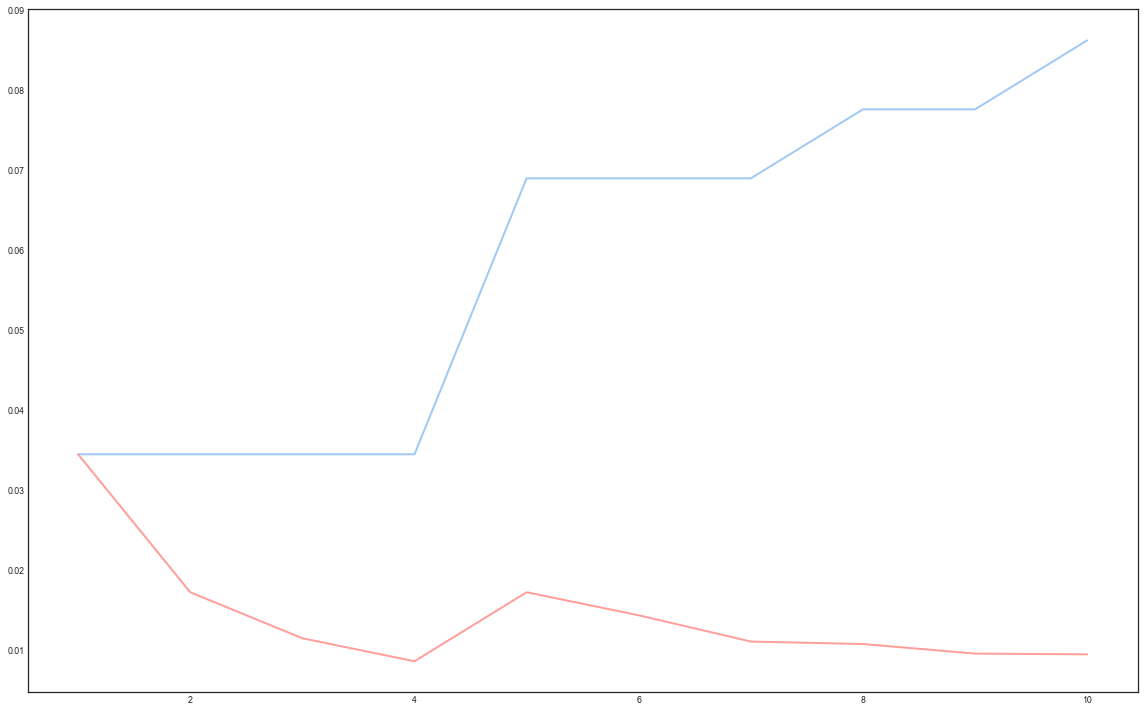

In [20]:
def plot(stemmed):
    fig = plt.figure() 
    ax = fig.add_subplot(111)
    fig.set_size_inches(16, 10)
    x_vals = [x for x in range(1, 11)]
    ax.plot(x_vals, [[len([v for v in exp.values() if len(v) != 0]) / len(exp)] for exp in stemmed], color='b', linewidth=2)
    ax.plot(x_vals, [statistics.mean([len(v)/(i+1) for v in exp.values()]) for i, exp in enumerate(stemmed)], color='r', linewidth=2)
    
    fig.tight_layout()
   
plot(stemmed_expansions)

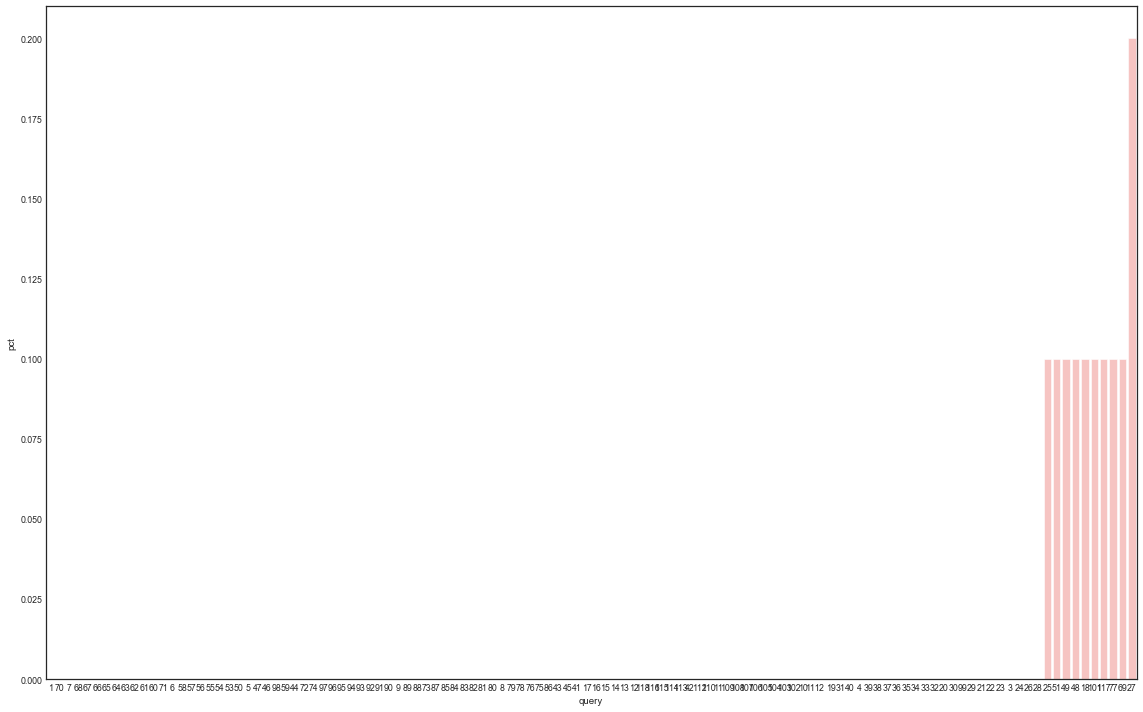

In [21]:
def plot_qry(stemmed):
    fig = plt.figure() 
    ax = fig.add_subplot(111)
    fig.set_size_inches(16, 10)
    df = pd.DataFrame({'query': list(stemmed.keys()), 'pct': [len(v)/(i+1) for k, v in stemmed.items()]})
    result = df.groupby(["query"])['pct'].aggregate(np.median).reset_index().sort_values('pct')
    sns.barplot(x='query', y='pct', data=df, order=result['query'], ax=ax, color='r', alpha=0.7)
    fig.tight_layout()
   
plot_qry(stemmed_expansions[-1])

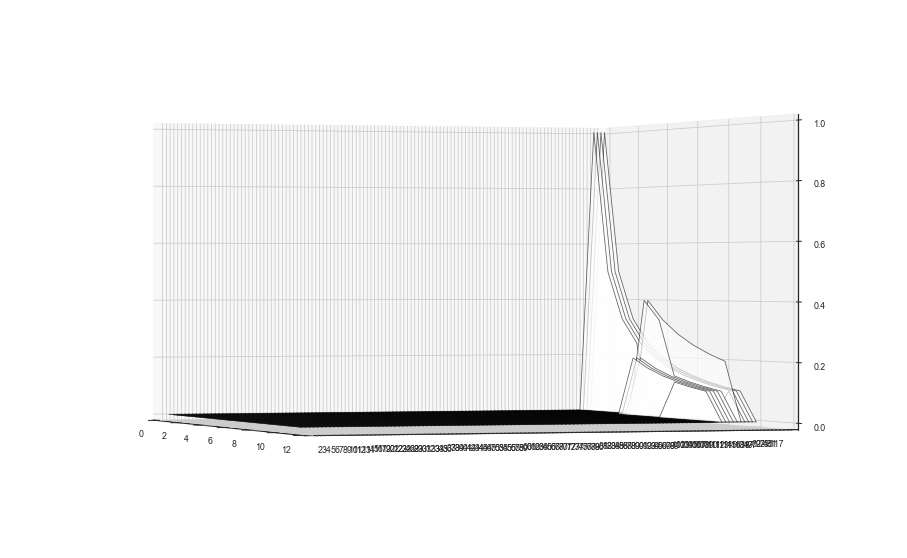

In [28]:
import matplotlib.ticker as plticker

loc = plticker.MultipleLocator(base=1.0)

fig = plt.figure() 
fig.set_size_inches(16, 10)
ax = fig.gca(projection='3d')

# df = pd.DataFrame({'query': list(stemmed_expansions[-1].keys()), 'pct': [len(v)/(i+1) for k, v in stemmed_expansions[-1].items()]})
# zs = list(df.sort_values(by='pct')['query'].values)
# zs = order
zs = [x[0] for x in sorted(avg_qry_score.items(), key=lambda item: item[1])]
xs = [x for x in range(0, 12)]
verts = []
for z in zs:
    ys = [len(x[z])/(i+1) for i, x in enumerate(stemmed_expansions)]
    ys = [0] + ys + [0]
    verts.append(list(zip(xs, ys)))

poly = PolyCollection(verts, facecolor='white')

new_zs = [x for x in range(len(zs))]
poly.set_alpha(0.6)
ax.add_collection3d(poly, zs=new_zs, zdir='y')

# ax.set_xlabel('X')
ax.set_xlim3d(0, 12)
# ax.set_ylabel('Y')
poly.set_edgecolor('black')
ax.set_ylim3d(-1, 118)
ax.set_yticklabels(zs)
ax.yaxis.set_major_locator(loc)
ax.view_init(0, 340)

In [23]:
avg_qry_score = {}
for i, exp in enumerate(stemmed_expansions):
    for k, v in exp.items(): 
        avg_qry_score[k] = avg_qry_score.get(k, 0) + len(v)/(i+1) 
        
avg_qry_score = {k: v/len(stemmed_expansions) for k, v in avg_qry_score.items()}

In [24]:
vals = {}

for i, exp in enumerate(stemmed_expansions):
    for k, v in exp.items(): 
        if k not in vals:
            vals[k] = []
        vals[k].append(len(v)/(i+1))

In [25]:
new_df = pd.DataFrame({'query': vals.keys(), 'scores': vals.items()})
new_df[[str(x+1) for x in range(0, 10)]] = pd.DataFrame(new_df['scores'].values.tolist())

ValueError: Columns must be same length as key

In [26]:

def seq_sort(seqs):
    ordered = []
    seen = set()
    for i in range(len(seqs)): 
        vals = np.array([len(v)/(i+1) for k, v in seqs[i].items() if k not in seen])
        keys = list(set(seqs[i].keys()) - seen)
        inds = np.argsort(vals)
        print(vals[inds[0]])
        for ind in inds:
            print(vals[ind])
            if vals[ind] != vals[inds[0]]:
                break
            
            seen.add(keys[ind])
            ordered.append(keys[ind])
        print(len(ordered))
    return ordered

order = seq_sort(stemmed_expansions)


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
112
0.0
0.0
0.0
0.0
0.0
116


IndexError: index 0 is out of bounds for axis 0 with size 0

In [1]:
def get_expansions(queries, expanded):
    out = {}
    for k, v in queries.items():
        tmp = {}
        for word, count in expanded[k].items():
            if word in v:
                n = v[word] - count  
                if n > 0:
                    tmp[word] = n 
            else: 
                tmp[word] = count 
            
        if len(tmp) > 0:
            out[k] = tmp 
        
    return out 
            
# for k, v in get_expansions(queries, expanded_queries[-1]).items():
#     print(k, [x for x in v])

In [13]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('punkt')
from nltk.tokenize import word_tokenize 

text = word_tokenize('reinstating liquidation regards money recovered')
print(text)
nltk.pos_tag(text)

[nltk_data] Downloading package punkt to /Users/danlocke/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


['reinstating', 'liquidation', 'regards', 'money', 'recovered']


LookupError: 
**********************************************************************
  Resource [93maveraged_perceptron_tagger[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtaggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle[0m

  Searched in:
    - '/Users/danlocke/nltk_data'
    - '/Library/Frameworks/Python.framework/Versions/3.6/nltk_data'
    - '/Library/Frameworks/Python.framework/Versions/3.6/share/nltk_data'
    - '/Library/Frameworks/Python.framework/Versions/3.6/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


In [10]:
for q, q_tokens in queries.items():
    print(q, list(q_tokens.keys()))

1 ['reinstating', 'liquidation', 'regards', 'money', 'recovered']
2 ['variation', 'settlement', 'writing']
3 ['maintenance', 'champerty', 'requisite', 'degree', 'control']
4 ['agency', 'fees', 'effective', 'cause', 'sale', 'boat']
5 ['damages', 'reduced', 'according', 'sum', 'represents', 'betterment']
6 ['consideration', 'clause', 'contract', 'buyer', 'satisfied', 'absolute', 'discretion', 'due', 'diligence']
7 ['maintenance', 'champerty']
8 ['proportionality', 'striking', 'defamation']
9 ['trade', 'commerce']
10 ['membership', 'organisation', 'trade', 'commerce']
11 ['organisations', 'owing', 'members', 'duty', 'care']
12 ['proprietary', 'relief', 'available', 'rescission']
13 ['exemplary', 'damages', 'retaining', 'benefit', 'brokerage', 'assessment']
14 ['consideration', '636', 'sustainable', 'planning']
15 ['google', 'search', 'results', 'defamation']
16 ['consideration', 'power', 'practice', 'directions', '17', 'supreme', 'queensland', '1991']
17 ['postponing', 'giving', 'particul